In [3]:
from sys import path
path.append('../')

# Forest Degredation in Vietnam using regression analysis on Landsat Imagery 
 

### This notebook:  

- applies a forest-degredation monitoring method across a time series of landsat imagery  
- displays a rendering of the computed products, 
- saves computed products off to disk for further validation.  
  

------  

<br>  
### Motivation   

This notebook is inspired by a publication titled **Assessment of Forest Degradation in Vietnam Using Landsat Time Series Data** authored by Vogelmann et al. You can snag a copy off of `mdpi` by following this [link](http://www.mdpi.com/1999-4907/8/7/238)  
  

-------
  
<br>  

### Algorithmic Profile  
  
- This algorithm generates a forest degredation product.
- The product is derived from Landsat7 Collection 1, Tier 2 sr imagery taken from USGS data holdings.    
- Linear Regression is run on an NDVI product, the linear coeffiecient(slope) is used as a proxy for forest degredation(NDVI decrease) 
-------  
  
<br>  

### Process  
For a select year   

- Compute the NDVI across all Landsat acquisitons    
- Select a time frame of **n** contiguous acquisitions  
- run linear regression on time-series stack of each ndvi pixel  
- capture slope in a lat,lon referenced grid
  
-------  
  
<br>  

>#### Flow Diagram  
> ![](./diagrams/Deforestation/ndvi_trend.png)  

  

-------  


  
------
  

# Calculations 

### NDVI  
NDVI is a derived index that correlates well with the existance of vegetation.  
  
<br>

$$ NDVI =  \frac{(NIR - RED)}{(NIR + RED)}$$  

<br>


In [14]:
def NDVI(dataset):
    return (dataset.nir - dataset.red)/(dataset.nir + dataset.red).rename("NDVI")

<br>  

## Linear Regression

The following code runs regression analysison every pixel.  


If it looks messy, that's probably because the underlying regression needs to handle `nan` values in a very peculiar way.    

In [15]:
import xarray as xr  
import numpy as np  

def _where_not_nan(arr):
    return np.where(np.isfinite(arr))

def _flatten_shallow(arr):
    return arr.reshape(arr.shape[0] * arr.shape[1])  

def per_pixel_linear_trend(pixel_da: xr.DataArray) -> xr.DataArray:
    time_index_length = len(pixel_da.time)  
    
    ys = _flatten_shallow(pixel_da.values)
    xs = np.array(list(range(time_index_length)))

    not_nan = _where_not_nan(ys)[0].astype(int)

    xs = xs[not_nan]
    ys = ys[not_nan] 

    pf = np.polyfit(xs,ys, 1)
    return xr.DataArray(pf[0])

def trend_product(da: xr.DataArray) -> xr.DataArray:
    stacked = da.stack(allpoints = ['latitude', 'longitude'])
    trend = stacked.groupby('allpoints').apply(per_pixel_linear_trend)
    unstacked = trend.unstack('allpoints')
    return unstacked.rename(dict(allpoints_level_0 = "latitude", allpoints_level_1 = "longitude"))


<br>  

### Cloud Masking 

In [11]:
import numpy as np

def is_clear_l7(dataset):    
    #Create boolean Masks for clear and water pixels
    clear_pixels = dataset.pixel_qa.values == 2 + 64
    water_pixels = dataset.pixel_qa.values == 4 + 64

    a_clean_mask = np.logical_or(clear_pixels, water_pixels)
    return a_clean_mask

<br>  

# Case study -- Colombia  

### Spatial Extents 

In [6]:
latitude = ( 4.5217, 4.5925)
longitude = (-71.7926, -71.6944)

### Display basemap of area  

In [7]:
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude = latitude, longitude =longitude)

### Load Data  

> #### Import datacube

In [8]:
import datacube
dc = datacube.Datacube()    

> Load data  

In [9]:
data = dc.load( latitude = latitude, 
                longitude = longitude,
                product = "ls7_ledaps_meta_river",
                measurements = ['red', 'nir', 'pixel_qa'])

### Create a cloud mask
Unclear pixels will be masked with a `nan` value.  We'll drop `pixel_qa` from the dataset to preserve memory. 

In [12]:
mask = is_clear_l7(data)  
data = data.drop(['pixel_qa'])

### Calculate NDVI  

In [16]:
data = NDVI(data)

### Filter clouded/occluded NDVI readings  

In [17]:
data = data.where(mask)
del mask

### Run regression  

In [18]:
from time import time 

t1 = time()
data = trend_product(data)
t2 = time()  

<br>  

In [19]:
print(t2 - t1)

78.46776175498962


### Plot trends below threshold 

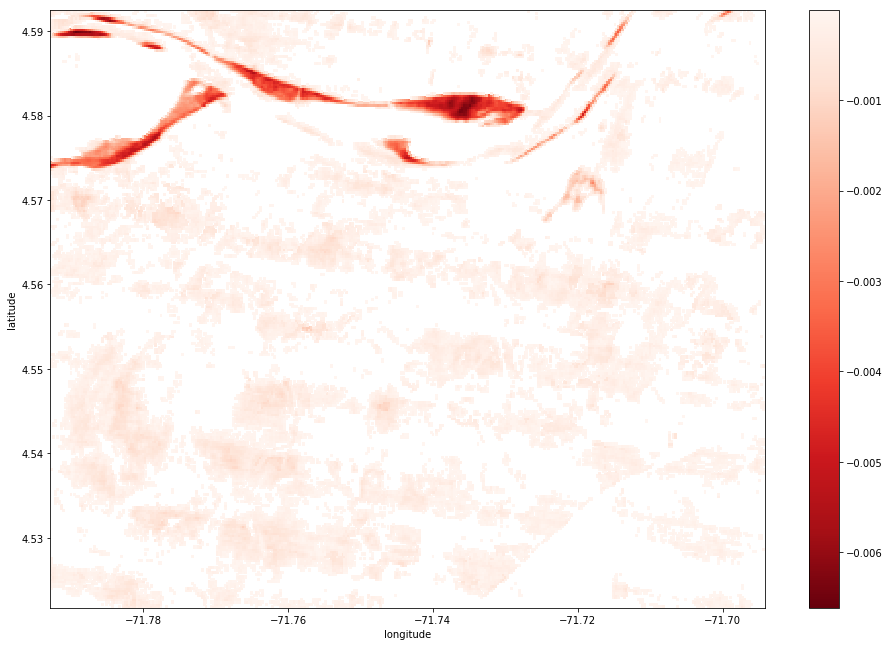

In [53]:
%matplotlib inline 
data.where(data< 0).plot(figsize = (16,11), cmap = 'Reds_r')

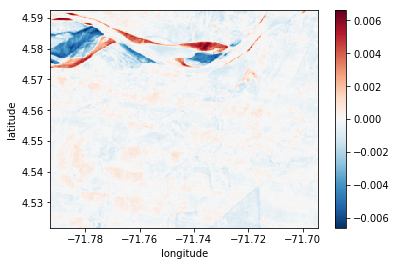

In [56]:
(-data).plot()

# Cited
1. Deutscher, Janik & Gutjahr, Karlheinz & Perko, Roland & Raggam, Hannes & Hirschmugl, Manuela & Schardt, Mathias. (2017). Humid Tropical Forest Monitoring with Multi-Temporal L-, C- and X-Band SAR Data. 10.1109/Multi-Temp.2017.8035264.
